# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [27]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
print("Data Points in Each class :")
print(filtered_data['Score'].value_counts()) 
filtered_data.head(3)

Number of data points in our data (525814, 10)
Data Points in Each class :
positive    443777
negative     82037
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting the data taking productid as the parameter
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(525814, 10)

In [5]:
#Deleting the dublicates reviews which is created when user writed a review for the product, it automatically generates for the same product of different color etc
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
#Dropping the data which has HelpfulnessNumerator<HelpfulnessDenominator which is impossible
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
#Checking to see how much % of data still remains
print("Percentage of data still remains",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

print("Final Data",final.shape)

Percentage of data still remains 69.25852107399194
Final Data (364171, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [60]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
from tqdm import tqdm
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:06<00:00, 665.88it/s]


In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [13]:
final_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [3]:
final = final_data.head(100000)
X_train_data = final[:60000]
X_test_data = final[60000:100000]
y_train = X_train_data['Score']
y_test = X_test_data['Score']
print("Data")
print(X_train_data.shape)
print(X_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(60000, 11)
(40000, 11)
Label
(60000,)
(40000,)


In [4]:
X_test_data['Score'].value_counts()

positive    34582
negative     5418
Name: Score, dtype: int64

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [16]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [4]:
#BoW on Text
print("**Bow Vectorizer**")
print("="*50)
count_vect = CountVectorizer()
X_train_BOW = count_vect.fit_transform(X_train_data['CleanedText'])
X_test_BOW = count_vect.transform(X_test_data['CleanedText'])
print(X_train_BOW.shape)
print(X_test_BOW.shape)

**Bow Vectorizer**
(60000, 29132)
(40000, 29132)


## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

In [22]:
#TFIDF on Text
print("**TFIDF Vectorizer**")
print("="*50)
tf_idf_vect = TfidfVectorizer()
X_train_tfidf = tf_idf_vect.fit_transform(X_train_data['CleanedText'])
X_test_tfidf = tf_idf_vect.transform(X_test_data['CleanedText'])
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

**TFIDF Vectorizer**
(60000, 29132)
(40000, 29132)


## [4.4] Word2Vec

In [61]:
import gensim
i=0
list_of_sent_train=[]
for sent in tqdm(X_train_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:17<00:00, 3504.02it/s]


In [62]:
import gensim
i=0
list_of_sent_test=[]
for sent in tqdm(X_test_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:12<00:00, 3225.34it/s]


In [63]:
print(X_train_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [64]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=6)

In [65]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

14907


In [66]:
w2v_model.wv.most_similar('good')

[('great', 0.820019543170929),
 ('decent', 0.7661885023117065),
 ('fantastic', 0.7292585372924805),
 ('yummy', 0.7175390124320984),
 ('bad', 0.7109501361846924),
 ('fine', 0.6947215795516968),
 ('wonderful', 0.6940157413482666),
 ('tasty', 0.6843613386154175),
 ('nice', 0.6800656318664551),
 ('terrific', 0.6749260425567627)]

In [67]:
w2v_model.wv.most_similar('tasty')

[('filling', 0.8324744701385498),
 ('satisfying', 0.8237539529800415),
 ('yummy', 0.8122594356536865),
 ('delicious', 0.7996281385421753),
 ('flavorful', 0.7254028916358948),
 ('moist', 0.7103576064109802),
 ('addictive', 0.6916539669036865),
 ('dense', 0.6902199983596802),
 ('light', 0.6884732842445374),
 ('nutritious', 0.6863570809364319)]

In [68]:
w2v_model.wv.most_similar('horrible')

[('awful', 0.9321525692939758),
 ('terrible', 0.9290462732315063),
 ('disgusting', 0.8623519539833069),
 ('funny', 0.8398271203041077),
 ('gross', 0.824905514717102),
 ('weird', 0.7612226605415344),
 ('strange', 0.7559704780578613),
 ('nasty', 0.7459670305252075),
 ('okay', 0.7311930656433105),
 ('ok', 0.7100555300712585)]

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [69]:
#TRAIN
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; 
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec) 
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:35<00:00, 279.03it/s]


60000
50


In [70]:
#TEST
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; 
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec) 
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:31<00:00, 263.69it/s]


40000
50


#### [4.4.1.2] TFIDF weighted W2v

In [71]:
tfidf_vect = TfidfVectorizer(min_df = 50)
train_tfidf_w2v = tfidf_vect.fit_transform(X_train_data["CleanedText"])
test_tfidf_w2v = tfidf_vect.transform(X_test_data["CleanedText"])
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))
print(train_tfidf_w2v.shape)
print(test_tfidf_w2v.shape)

(60000, 2951)
(40000, 2951)


In [72]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [07:49<00:00, 127.73it/s]


In [73]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [05:53<00:00, 113.17it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [49]:
X_train = X_train_BOW
X_test = X_test_BOW

In [50]:
max_depths = [3,4,5,6,7,8,9,10,11]
min_split = [5, 10, 100, 500]
param_grid = {'max_depth': max_depths,'min_samples_split':min_split}


model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1)
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.7688922695958512


In [51]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model
#Storing it into the dataframe and later plotting it into heatmap

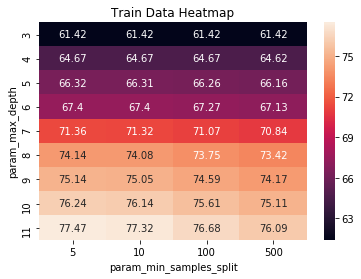

In [52]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('Train Data Heatmap')
plt.show()

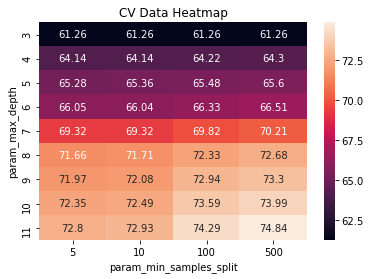

In [53]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('CV Data Heatmap')
plt.show()

In [54]:
optimal_depth = 11
optimal_split = 500

***Test Data Report***
Best max_depth =  11
Best min_samples_split =  500
AUC =  78.17512034620545


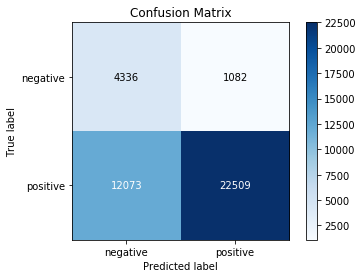

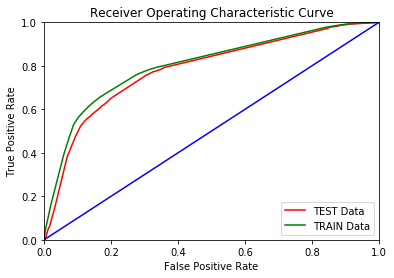

In [55]:
lr = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split =optimal_split, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [56]:
feature_name = count_vect.get_feature_names()
w = lr.feature_importances_ 
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [57]:
print("Top 20 features :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Top 20 features :
-------
great	-->	0.186790
best	-->	0.113268
disappoint	-->	0.090686
love	-->	0.089791
delici	-->	0.071927
excel	-->	0.041670
perfect	-->	0.035028
favorit	-->	0.034536
good	-->	0.028687
bad	-->	0.024647
thought	-->	0.024129
nice	-->	0.018794
wonder	-->	0.015806
howev	-->	0.015724
tast	-->	0.014607
would	-->	0.014598
product	-->	0.012589
hope	-->	0.012294
terribl	-->	0.011665


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

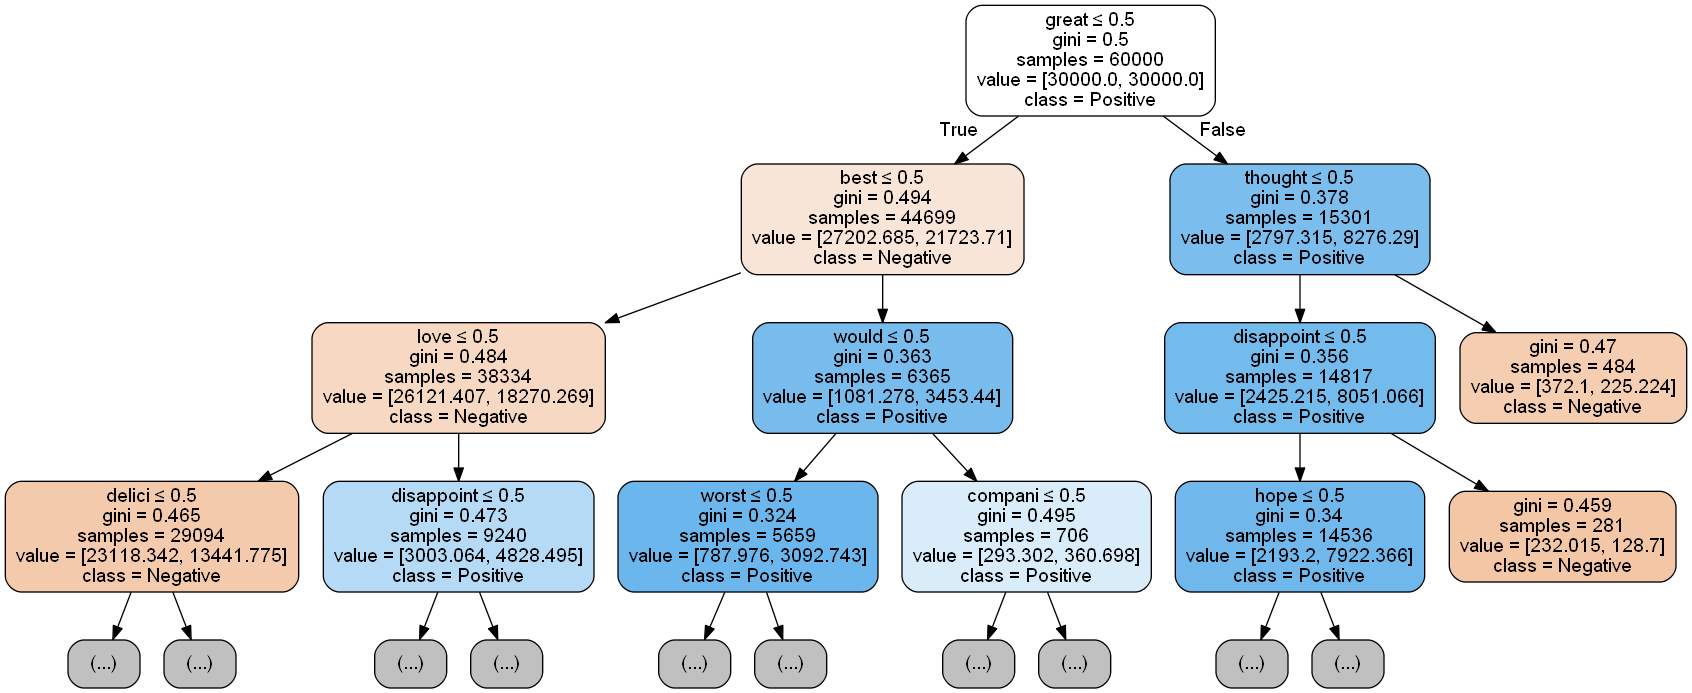

In [58]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

export_graphviz(lr, max_depth=3, out_file=dot_data,  
                filled=True, rounded=True, feature_names=feature_name,
                special_characters=True,class_names=['Negative','Positive'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [39]:
X_train = X_train_tfidf
X_test = X_test_tfidf

In [40]:
max_depths = [3,4,5,6,7,8,9,10,11]
min_split = [5, 10, 100, 500]
param_grid = {'max_depth': max_depths,'min_samples_split':min_split}


model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1)
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.7561631280345095


In [41]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model
#Storing it into the dataframe and later plotting it into heatmap

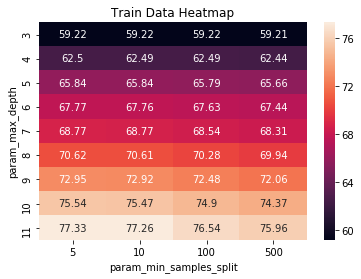

In [42]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('Train Data Heatmap')
plt.show()

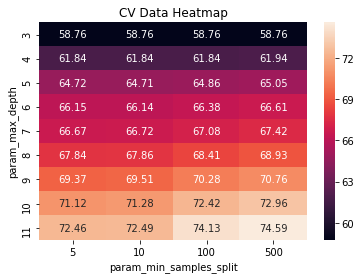

In [43]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('CV Data Heatmap')
plt.show()

In [44]:
optimal_depth = 11
optimal_split = 500

***Test Data Report***
Best max_depth =  11
Best min_samples_split =  500
AUC =  80.45766361745706


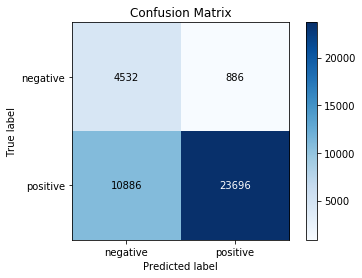

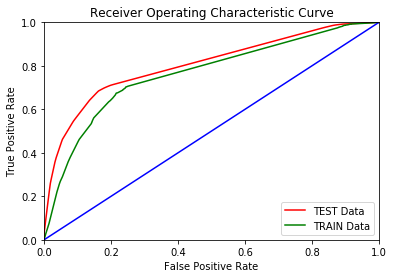

In [45]:
lr = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split =optimal_split, class_weight='balanced')
lr.fit(X_test,y_test)
pred = lr.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [46]:
feature_name = tf_idf_vect.get_feature_names()
w = lr.feature_importances_ 
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [47]:
print("Top 20 features :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Top 20 features :
-------
great	-->	0.201859
love	-->	0.109540
best	-->	0.105428
disappoint	-->	0.090735
delici	-->	0.075654
favorit	-->	0.045947
good	-->	0.039681
excel	-->	0.033474
perfect	-->	0.032291
easi	-->	0.021314
thought	-->	0.021107
bad	-->	0.020806
amaz	-->	0.019545
stale	-->	0.018004
worst	-->	0.009370
away	-->	0.009355
wast	-->	0.008710
tast	-->	0.008478
would	-->	0.007649


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

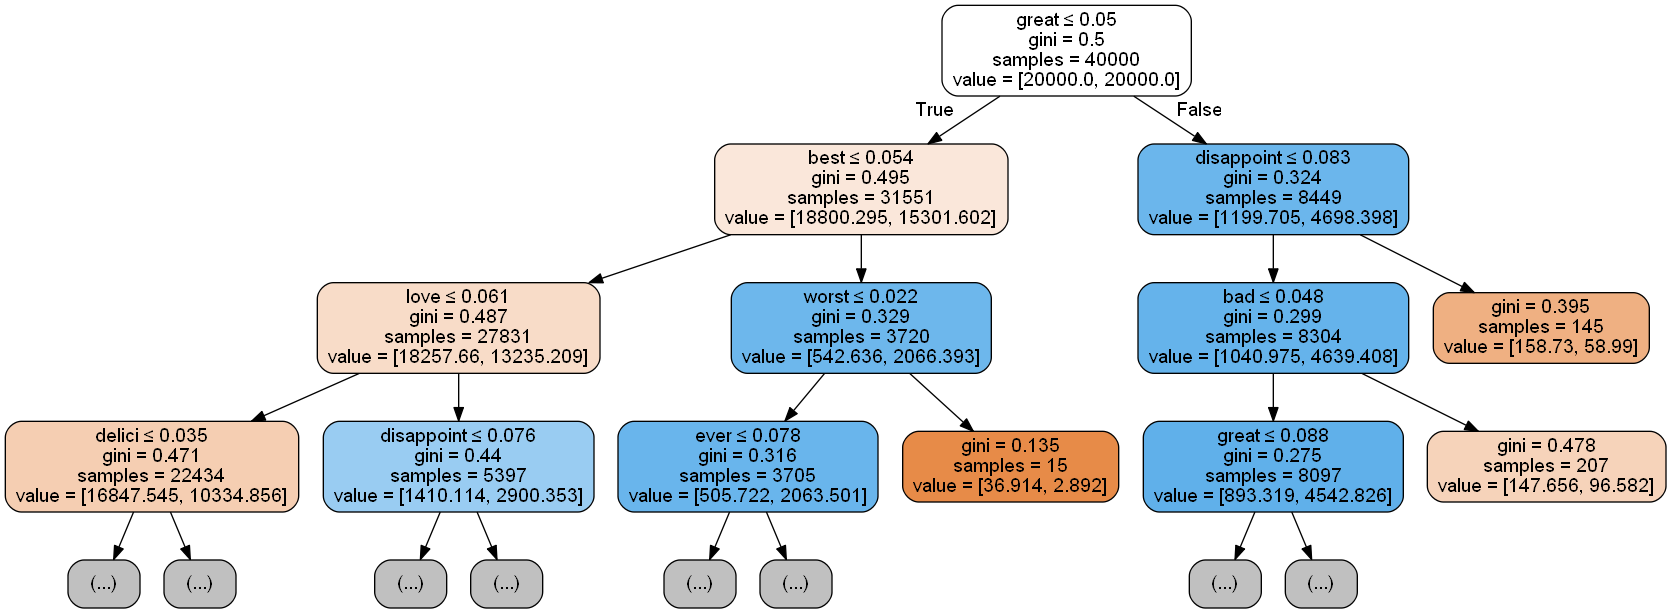

In [48]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

export_graphviz(lr, max_depth=3, out_file=dot_data,  
                filled=True, rounded=True, feature_names=feature_name,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [74]:
X_train = sent_vectors_train
X_test = sent_vectors_test

In [75]:
max_depths = [3,4,5,6,7,8,9,10,11]
min_split = [5, 10, 100, 500]
param_grid = {'max_depth': max_depths,'min_samples_split':min_split}


model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1)
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.8335264241306481


In [76]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model
#Storing it into the dataframe and later plotting it into heatmap

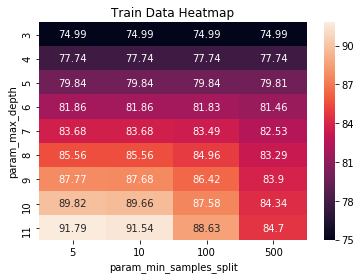

In [77]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('Train Data Heatmap')
plt.show()

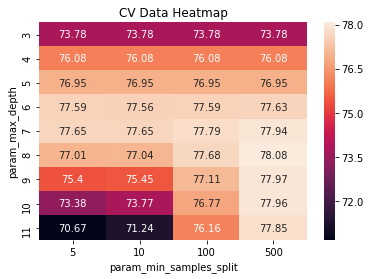

In [78]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('CV Data Heatmap')
plt.show()

In [79]:
optimal_depth = 8
optimal_split = 500

***Test Data Report***
Best max_depth =  8
Best min_samples_split =  500
AUC =  84.4741605162741


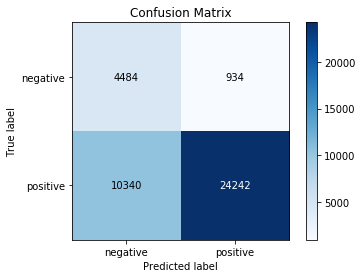

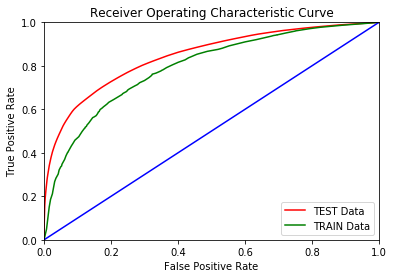

In [80]:
lr = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split =optimal_split, class_weight='balanced')
lr.fit(X_test,y_test)
pred = lr.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [82]:
X_train = tfidf_sent_vectors_train
X_test = tfidf_sent_vectors_test

In [83]:
max_depths = [3,4,5,6,7,8,9,10,11]
min_split = [5, 10, 100, 500]
param_grid = {'max_depth': max_depths,'min_samples_split':min_split}


model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1)
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.7732260517621791


In [84]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model
#Storing it into the dataframe and later plotting it into heatmap

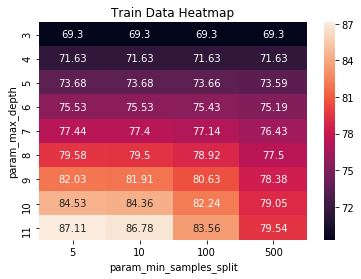

In [85]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('Train Data Heatmap')
plt.show()

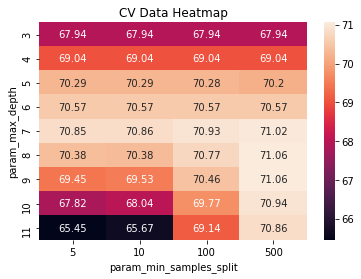

In [86]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('CV Data Heatmap')
plt.show()

In [87]:
optimal_depth = 8
optimal_split = 500

***Test Data Report***
Best max_depth =  8
Best min_samples_split =  500
AUC =  78.62904517056832


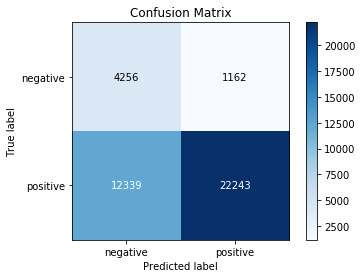

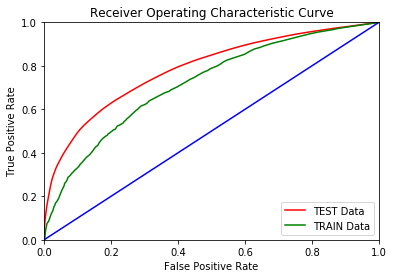

In [88]:
lr = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split =optimal_split, class_weight='balanced')
lr.fit(X_test,y_test)
pred = lr.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [89]:
#importing library
from prettytable import PrettyTable
x = PrettyTable()

#adding Field names
x.field_names = ["SL No.","Vectorizer","Best (max_depth)","Best (min_samples_split)","AUC"]

# adding row to table
x.title = 'Decision Trees'
x.add_row(["1","BOW",11,500,78.1751])
x.add_row(["2","TFIDF",11,500,80.4577])
x.add_row(["3","Avg-W2vec",8,500,84.4741])
x.add_row(["4","TFIDF-W2vec",8,500,78.6290])

#printing the table
print(x)

+--------+-------------+------------------+--------------------------+---------+
| SL No. |  Vectorizer | Best (max_depth) | Best (min_samples_split) |   AUC   |
+--------+-------------+------------------+--------------------------+---------+
|   1    |     BOW     |        11        |           500            | 78.1751 |
|   2    |    TFIDF    |        11        |           500            | 80.4577 |
|   3    |  Avg-W2vec  |        8         |           500            | 84.4741 |
|   4    | TFIDF-W2vec |        8         |           500            |  78.629 |
+--------+-------------+------------------+--------------------------+---------+


## Conclusion
- AVG W2VECgives the best AUC Score amoung the models on test data i.e 84.5877
- TFIDF-W2vec gives the the least AUC Score among the models.
- Decision trees models have lower accuracy rates as compared to other models like logistic regression, naive bayes